<a href="https://colab.research.google.com/github/sal0m/RecSys_HSE_2025/blob/main/HSE_RecSys_HW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ДЗ №2. Матричные факторизации

#### В этой домашке вам предстоит реализовать некоторые базовые модели матричной факторизации

#### Дата выдачи: 17.02.25

#### Мягкий дедлайн: 02.03.25 23:59 MSK

#### Жесткий дедлайн: 09.03.25 23:59 MSK

В этом задании мы будем работать с классическим для рекоендательных систем датасетом [MovieLens 1M](https://grouplens.org/datasets/movielens/1m/). Датасет содержит рейтинги оценки для 4000 фильмов от 6000 пользователей. Более подробное описание можете найти на странице с датасетом и в README файле

In [1]:
!wget https://files.grouplens.org/datasets/movielens/ml-1m.zip
!unzip ml-1m.zip
!cat ml-1m/README

--2025-03-02 20:38:46--  https://files.grouplens.org/datasets/movielens/ml-1m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5917549 (5.6M) [application/zip]
Saving to: ‘ml-1m.zip’

ml-1m.zip           100%[===================>]   5.64M  3.09MB/s    in 1.8s    

2025-03-02 20:38:49 (3.09 MB/s) - ‘ml-1m.zip’ saved [5917549/5917549]

Archive:  ml-1m.zip
   creating: ml-1m/
  inflating: ml-1m/movies.dat        
  inflating: ml-1m/ratings.dat       
  inflating: ml-1m/README            
  inflating: ml-1m/users.dat         
SUMMARY

These files contain 1,000,209 anonymous ratings of approximately 3,900 movies 
made by 6,040 MovieLens users who joined MovieLens in 2000.

USAGE LICENSE

Neither the University of Minnesota nor any of the researchers
involved can guarantee the correctness of the data, its suitability
for any

In [2]:
import pandas as pd
import numpy as np
from typing import Union

In [3]:
df = pd.read_csv("ml-1m/ratings.dat", sep='::', names=['user_id', 'item_id', 'rating', 'timestamp'], engine='python')
df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')
df.drop('timestamp', axis=1, inplace=True)
df.head()

,user_id,item_id,rating,datetime
0,1,1193,5,2000-12-31 22:12:40
1,1,661,3,2000-12-31 22:35:09
2,1,914,3,2000-12-31 22:32:48
3,1,3408,4,2000-12-31 22:04:35
4,1,2355,5,2001-01-06 23:38:11


In [4]:
value_counts = df['item_id'].value_counts()
filtered_values = value_counts[value_counts > 20].index
df = df[df['item_id'].isin(filtered_values)].copy()

In [5]:
train_end = '2000-12-01'
df_train = df[df['datetime'] < train_end].copy()
df_test = df[df['datetime'] >= train_end].copy()
df_train.shape, df_test.shape

((787420, 4), (207432, 4))

In [6]:
train_users = df_train['user_id'].unique()
train_items = df_train['item_id'].unique()

df_test = df_test[df_test['user_id'].isin(train_users)]
df_test = df_test[df_test['item_id'].isin(train_items)]
df_test.shape

(106471, 4)

In [7]:
from sklearn.preprocessing import LabelEncoder

user_le = LabelEncoder()
item_le = LabelEncoder()

df_train['user_id'] = user_le.fit_transform(df_train['user_id'])
df_train['item_id'] = item_le.fit_transform(df_train['item_id'])

df_test['user_id'] = user_le.transform(df_test['user_id'])
df_test['item_id'] = item_le.transform(df_test['item_id'])

In [8]:
df_train['user_id'].nunique(), df_train['user_id'].max()
df_train['item_id'].nunique(), df_train['item_id'].max()

(3010, 3009)

##### Задание 1. Напишем функцию, которая превратит датафрейм в матрицу интеракций. В функции df_to_matrix реализуйте функцию, которая принимает датафрейм и возвращает np.array матрицу интеракций. В функции df_to_coo реализуйте функцию, которая принимает датафрейм и возвращает разреженную матрицу интеракций в coo_array формате

In [31]:
df_train

,user_id,item_id,rating,datetime
100409,0,2994,3,2000-11-30 23:49:23
100411,0,929,4,2000-11-30 23:52:33
100412,0,567,4,2000-11-30 23:51:54
100415,0,3005,1,2000-11-30 23:58:06
100416,0,3006,4,2000-11-30 23:57:50
...,...,...,...,...
1000204,5364,814,1,2000-04-26 02:35:41
1000205,5364,817,5,2000-04-25 23:21:27
1000206,5364,478,5,2000-04-25 23:19:06
1000207,5364,819,4,2000-04-26 02:20:48


In [9]:
def df_to_matrix(df: pd.DataFrame) -> np.ndarray:

    n_users = df['user_id'].max() + 1
    n_items = df['item_id'].max() + 1

    matrix = np.zeros((n_users, n_items))
    matrix[df['user_id'], df['item_id']] = df['rating']

    return matrix #shape ~ [n_users, n_items]

In [10]:
interactions = df_to_matrix(df_train)

In [142]:
interactions

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [3., 0., 0., ..., 0., 0., 0.]])

In [11]:
from scipy.sparse import coo_array, coo_matrix

def df_to_coo(df: pd.DataFrame) -> coo_matrix:

    rows = df['user_id'].values
    cols = df['item_id'].values
    data = df['rating'].values

    result = coo_matrix((data, (rows, cols)))

    return result # coo_matrix

In [12]:
coo_interactions = df_to_coo(df_train)

In [12]:
assert (interactions != 0).sum() == df_train.shape[0]
assert interactions[0, 2994] == 3
assert interactions[2369, 1203] == 5
assert interactions[1557, 459] == 3
assert np.allclose(coo_interactions.toarray(), interactions)

##### Задание 2.1. Рассмотрим [SVD](https://en.wikipedia.org/wiki/Singular_value_decomposition). Возьмите готовую реализуцию алгоритма из numpy.linalg или из scipy.linalg и примените алгоритм к матрицам интеракций, полученным в первом задании. Для работы со sparse матрицей обычная реализация svd не подойдет и нужно будет воспользоваться scipy.sparse.linalg.svds. Вам нужно разложить матрицу интеракций на 3 матрицы U, S, V, а затем перемножить их и восстановить изначальную матрицу. При полном разложении исходная матрица должна восстанавливаться максимально хорошо

In [13]:
import numpy as np
from scipy.sparse.linalg import svds
from typing import Union

In [14]:
import numpy as np
from scipy.sparse.linalg import svds
from scipy.sparse import coo_matrix
from typing import Union

def make_svd(interactions: Union[np.ndarray, coo_matrix], n_singular_values: int = -1):

    if isinstance(interactions, np.ndarray):
        # Для плотной матрицы используем numpy.linalg.svd
        U, S, Vt = np.linalg.svd(interactions, full_matrices=False)

        if n_singular_values != -1:
            U = U[:, :n_singular_values]
            S = np.diag(S[:n_singular_values])
            Vt = Vt[:n_singular_values, :]
        else:
            S = np.diag(S)

    elif isinstance(interactions, coo_matrix):
        # Для разреженной матрицы используем scipy.sparse.linalg.svds
        if n_singular_values == -1:
            n_singular_values = min(interactions.shape) - 1

        if not np.issubdtype(interactions.dtype, np.floating):
            interactions = interactions.astype(np.float64)

        U, S, Vt = svds(interactions, k=n_singular_values)

        sorted_indices = np.argsort(S)[::-1]
        U = U[:, sorted_indices]
        S = np.diag(S[sorted_indices])
        Vt = Vt[sorted_indices, :]

    else:
        raise TypeError("Неподдерживаемый тип данных. Ожидается np.ndarray или scipy.sparse.coo_matrix.")

    return U, S, Vt

In [149]:
U, S, V = make_svd(interactions)
assert np.allclose(U @ S @ V, interactions)

In [163]:
U1, S1, V1 = make_svd(interactions, 10)
U, S, V = make_svd(coo_interactions, 10)
assert np.allclose(U1 @ S1 @ V1, U @ S @ V)

##### Задание 2.2. Теперь попробуем сделать рекомендации с помощью SVD. Мы научились восстанавливать исходную матрицу с помощью разложения, теперь же мы хотим порекомендовать пользователю айтемы, которые будут для него максимально релевантны(в восстановленной матрице у них будет самый высокий скор). Для каждого пользователя нужно будет найти индексы айтемов, которые имеют максимальный скор. При этом стоит обратить внимание, что мы не хотим рекомендовать пользователю айтемы, с которыми он уже взаимодействовал

In [15]:
def make_svd_recommendations(interactions: Union[np.ndarray, coo_matrix], n_singular_values: int = -1, top_k: int = 100):
    # Возвращает матрицу вида n_users, top_k, то есть для каждого пользователя возвращаем индексы
    # top_k самых релевантный айтемов среди тех с которыми он еще не взаимодействовал

    U, S, Vt = make_svd(interactions, n_singular_values)

    predicted_matrix = np.dot(U, np.dot(S, Vt))

    if isinstance(interactions, coo_matrix):
        interactions = interactions.toarray()

    n_users = interactions.shape[0]
    recommendations = np.zeros((n_users, top_k), dtype=int)

    for user_id in range(n_users):
        predicted_ratings = predicted_matrix[user_id]
        interacted_items = interactions[user_id] != 0
        predicted_ratings[interacted_items] = -np.inf
        top_items = np.argsort(predicted_ratings)[::-1][:top_k]
        recommendations[user_id] = top_items

    return recommendations  # shape ~ [n_users, top_k]

In [169]:
recs = make_svd_recommendations(interactions, -1, 100)
assert recs.shape == (interactions.shape[0], 100)

##### Задание 2.3. Теперь давайте посмотрим как будет зависеть качетво рекомендаций, от количества сингулярных чисел, которые мы возьмем в SVD разложении. Переберите n_singular_values из списка [1, 10, 50, 200, 1000] и посмотрите как будет изменяться метрика NDCG на тестовом датасете для таких рекомендаций и как будет меняться время вычисления. Для каждого графики зависимости метрики NDCG от n_singular_values и времени работы алгоритма от n_singular_values(Время работы будет меняться только для sparse-матрицы, стоит запускать алгоритм именно для нее)

In [26]:
import time
import matplotlib.pyplot as plt
from sklearn.metrics import ndcg_score
from scipy.sparse import coo_matrix, csr_matrix

In [23]:
df_test.shape[0]

106471

In [24]:
df_test.shape

(106471, 4)

In [20]:
interactions_test = df_to_matrix(df_test)

In [47]:
interactions_test.shape #5365 юзеров и 3010 айтемов

(5365, 3010)

In [18]:
def evaluate_ndcg(recommendations, test_data, top_k=100):
    ndcg_values = []

    for user_id in range(test_data.shape[0]):
        if isinstance(test_data, csr_matrix):
            relevant_items = test_data[user_id].toarray().flatten()
        else:
            relevant_items = test_data[user_id]

        if relevant_items.sum() == 0: #пропускаем юзера, если у него вдруг нет в тесте взаимодействий (мало ли, хотя как он туда тогда попал..)
            continue
        if user_id not in recommendations:  # пропускаем юзера, если его нет в трейне
            continue

        recommended_items = np.zeros_like(relevant_items)
        recommended_items[recommendations[user_id][:top_k]] = 1

        ndcg = ndcg_score([relevant_items], [recommended_items])
        ndcg_values.append(ndcg)

    return np.mean(ndcg_values) if ndcg_values else 0.0

In [15]:
def plot_graphs(interactions: Union[np.ndarray, coo_matrix], test_data: np.ndarray, top_k: int = 100):
    n_values = [1, 10, 50, 200, 1000]
    ndcg_scores = []
    times = []

    for n_singular_values in n_values:
        start_time = time.time()

        recommendations = make_svd_recommendations(interactions, n_singular_values, top_k)

        elapsed_time = time.time() - start_time
        times.append(elapsed_time)

        ndcg = evaluate_ndcg(recommendations, test_data, top_k)
        ndcg_scores.append(ndcg)

        print(f"n_singular_values: {n_singular_values}, NDCG: {ndcg:.4f}, Time: {elapsed_time:.4f} sec")

    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.plot(n_values, ndcg_scores, marker='o', linestyle='-')
    plt.xlabel("Число сингулярных значений")
    plt.ylabel("NDCG@k")
    plt.title("Зависимость NDCG от числа сингулярных значений")
    plt.xscale("log")

    plt.subplot(1, 2, 2)
    plt.plot(n_values, times, marker='o', linestyle='-', color='red')
    plt.xlabel("Число сингулярных значений")
    plt.ylabel("Время работы (сек)")
    plt.title("Зависимость времени работы от числа сингулярных значений")
    plt.xscale("log")

    plt.tight_layout()

n_singular_values: 1, NDCG: 0.4592, Time: 55.5359 sec
n_singular_values: 10, NDCG: 0.4658, Time: 54.1641 sec
n_singular_values: 50, NDCG: 0.4477, Time: 70.7892 sec
n_singular_values: 200, NDCG: 0.4282, Time: 55.7463 sec
n_singular_values: 1000, NDCG: 0.3764, Time: 56.9269 sec


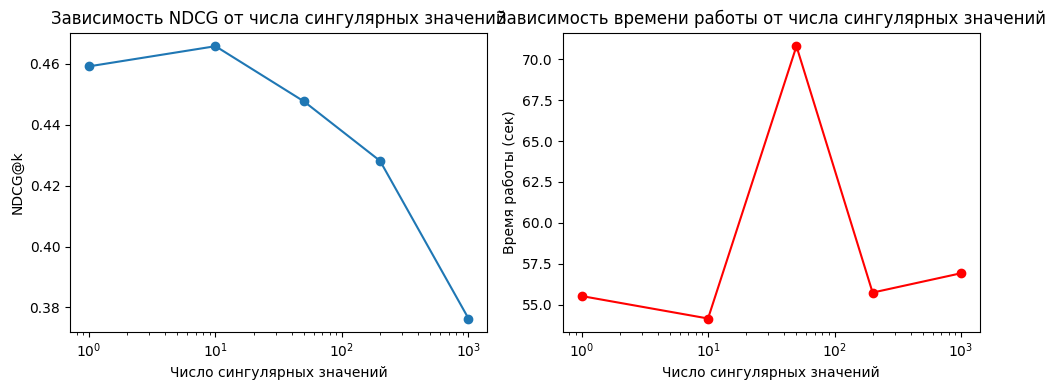

In [55]:
plot_graphs(coo_interactions, interactions_test)

по NDCG график легко объяснить: примерно оптимальное кол-во сингулярных чисел = 10, если берем больше - переобучаемся и метрика падает

с временем график странный скорее всего из-за приколов с замером времени в колабе. по логике время должно расти с увеличением числа сингулярных чисел (тк растет кол-во ненулевых значений в матрице)

##### Задание 3.1. Перейдем к [ALS](http://yifanhu.net/PUB/cf.pdf). Возьмем реализацию iALS из библиотеки [implicit](https://benfred.github.io/implicit/api/models/cpu/als.html). Обучите ALS на нашем датасете, сделайте top_k рекомендации для юзеров из тестового датасета, и сравните метрики ALS с метриками, которые получились в SVD. Попробуйте перебрать гиперпараметры и найдите оптимальное число факторов, коэффициент alpha и коэффициент регуляризации.

In [23]:
pip install implicit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 116.8 MB/s eta 0:00:00


In [24]:
from implicit.als import AlternatingLeastSquares
from implicit.evaluation import ndcg_at_k
from scipy.sparse import coo_matrix, csr_matrix

In [58]:
coo_interactions_test = df_to_coo(df_test)

In [17]:
def make_als_recommendations(
    interactions: Union[np.ndarray, coo_array],
    top_k: int = 100,
    n_factors: int = 100,
    alpha: float = 1.0,
    regularization: float = 0.01,
    iterations: int = 15
):
    start_time = time.time()
    if isinstance(interactions, np.ndarray):
        interactions = interactions.tocsr()
    elif not isinstance(interactions, csr_matrix):
        interactions = interactions.tocsr()

    model = AlternatingLeastSquares(
        factors=n_factors,
        regularization=regularization,
        iterations=iterations,
        random_state=42,
        alpha=alpha
    )

    model.fit(interactions)

    recommendations = np.zeros((interactions.shape[0], top_k), dtype=int)
    for user_id in range(interactions.shape[0]):
        recommended_items, _ = model.recommend(
            user_id,
            interactions[user_id],
            N=top_k,
            filter_already_liked_items=True
        )
        recommendations[user_id] = recommended_items

    elapsed_time = time.time() - start_time
    print(f"ALS обучение + рекомендации заняли {elapsed_time:.4f} сек")

    return recommendations #shape ~ [n_users, top_k]

In [62]:
recs_als = make_als_recommendations(coo_interactions)
assert recs.shape == (coo_interactions.shape[0], 100)

  0%|          | 0/15 [00:00<?, ?it/s]

ALS обучение + рекомендации заняли 16.4912 сек


In [63]:
evaluate_ndcg(recs_als, interactions_test)

0.4425380123378048

In [65]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 2.6 MB/s eta 0:00:00


In [69]:
import optuna

def objective(trial):
    n_factors = trial.suggest_categorical("n_factors", [16, 32, 64, 128, 256])
    alpha = trial.suggest_int("alpha", 1, 100, step=10)
    reg = trial.suggest_float("regularization", 0.001, 1.0, log=True)

    recs = make_als_recommendations(
        coo_interactions, top_k=100, n_factors=n_factors, alpha=alpha, regularization=reg
    )

    ndcg_als = evaluate_ndcg(recs, interactions_test)

    print(f"n_factors={n_factors}, alpha={alpha}, reg={reg} → NDCG@100={ndcg_als:.4f}")

    return ndcg_als

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

print(f"\nЛучшие параметры: {study.best_params}, NDCG@100={study.best_value:.4f}")


[I 2025-03-02 17:18:38,075] A new study created in memory with name: no-name-2326c594-a0ad-4968-a322-87afdf59a48d
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [1, 100] and step=10, but the range is not divisible by `step`. It will be replaced by [1, 91].
  warnings.warn(


  0%|          | 0/15 [00:00<?, ?it/s]

ALS обучение + рекомендации заняли 10.2453 сек


[I 2025-03-02 17:18:49,642] Trial 0 finished with value: 0.4497053522909224 and parameters: {'n_factors': 64, 'alpha': 1, 'regularization': 0.6813849717072634}. Best is trial 0 with value: 0.4497053522909224.


n_factors=64, alpha=1, reg=0.6813849717072634 → NDCG@100=0.4497


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [1, 100] and step=10, but the range is not divisible by `step`. It will be replaced by [1, 91].
  warnings.warn(


  0%|          | 0/15 [00:00<?, ?it/s]

ALS обучение + рекомендации заняли 51.0070 сек


[I 2025-03-02 17:19:42,126] Trial 1 finished with value: 0.4228294544307428 and parameters: {'n_factors': 256, 'alpha': 21, 'regularization': 0.012904614180183446}. Best is trial 0 with value: 0.4497053522909224.


n_factors=256, alpha=21, reg=0.012904614180183446 → NDCG@100=0.4228


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [1, 100] and step=10, but the range is not divisible by `step`. It will be replaced by [1, 91].
  warnings.warn(


  0%|          | 0/15 [00:00<?, ?it/s]

ALS обучение + рекомендации заняли 8.7223 сек


[I 2025-03-02 17:19:52,785] Trial 2 finished with value: 0.43762719622308094 and parameters: {'n_factors': 16, 'alpha': 41, 'regularization': 0.002248823435563654}. Best is trial 0 with value: 0.4497053522909224.


n_factors=16, alpha=41, reg=0.002248823435563654 → NDCG@100=0.4376


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [1, 100] and step=10, but the range is not divisible by `step`. It will be replaced by [1, 91].
  warnings.warn(


  0%|          | 0/15 [00:00<?, ?it/s]

ALS обучение + рекомендации заняли 7.6126 сек


[I 2025-03-02 17:20:01,994] Trial 3 finished with value: 0.4221216730316774 and parameters: {'n_factors': 32, 'alpha': 91, 'regularization': 0.0019347364496687157}. Best is trial 0 with value: 0.4497053522909224.


n_factors=32, alpha=91, reg=0.0019347364496687157 → NDCG@100=0.4221


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [1, 100] and step=10, but the range is not divisible by `step`. It will be replaced by [1, 91].
  warnings.warn(


  0%|          | 0/15 [00:00<?, ?it/s]

ALS обучение + рекомендации заняли 8.8541 сек


[I 2025-03-02 17:20:12,282] Trial 4 finished with value: 0.4389044476567123 and parameters: {'n_factors': 32, 'alpha': 21, 'regularization': 0.02089892915785571}. Best is trial 0 with value: 0.4497053522909224.


n_factors=32, alpha=21, reg=0.02089892915785571 → NDCG@100=0.4389


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [1, 100] and step=10, but the range is not divisible by `step`. It will be replaced by [1, 91].
  warnings.warn(


  0%|          | 0/15 [00:00<?, ?it/s]

ALS обучение + рекомендации заняли 9.1745 сек


[I 2025-03-02 17:20:22,564] Trial 5 finished with value: 0.4538633869332989 and parameters: {'n_factors': 16, 'alpha': 1, 'regularization': 0.024125415043264653}. Best is trial 5 with value: 0.4538633869332989.


n_factors=16, alpha=1, reg=0.024125415043264653 → NDCG@100=0.4539


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [1, 100] and step=10, but the range is not divisible by `step`. It will be replaced by [1, 91].
  warnings.warn(


  0%|          | 0/15 [00:00<?, ?it/s]

ALS обучение + рекомендации заняли 9.5745 сек


[I 2025-03-02 17:20:33,873] Trial 6 finished with value: 0.43093612585783053 and parameters: {'n_factors': 64, 'alpha': 51, 'regularization': 0.03732516777461229}. Best is trial 5 with value: 0.4538633869332989.


n_factors=64, alpha=51, reg=0.03732516777461229 → NDCG@100=0.4309


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [1, 100] and step=10, but the range is not divisible by `step`. It will be replaced by [1, 91].
  warnings.warn(


  0%|          | 0/15 [00:00<?, ?it/s]

ALS обучение + рекомендации заняли 7.5074 сек


[I 2025-03-02 17:20:42,984] Trial 7 finished with value: 0.43381720717905653 and parameters: {'n_factors': 32, 'alpha': 31, 'regularization': 0.10550239058469497}. Best is trial 5 with value: 0.4538633869332989.


n_factors=32, alpha=31, reg=0.10550239058469497 → NDCG@100=0.4338


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [1, 100] and step=10, but the range is not divisible by `step`. It will be replaced by [1, 91].
  warnings.warn(


  0%|          | 0/15 [00:00<?, ?it/s]

ALS обучение + рекомендации заняли 18.3901 сек


[I 2025-03-02 17:21:03,959] Trial 8 finished with value: 0.43304565735875217 and parameters: {'n_factors': 16, 'alpha': 51, 'regularization': 0.004481060488117716}. Best is trial 5 with value: 0.4538633869332989.


n_factors=16, alpha=51, reg=0.004481060488117716 → NDCG@100=0.4330


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [1, 100] and step=10, but the range is not divisible by `step`. It will be replaced by [1, 91].
  warnings.warn(


  0%|          | 0/15 [00:00<?, ?it/s]

ALS обучение + рекомендации заняли 9.7695 сек


[I 2025-03-02 17:21:14,985] Trial 9 finished with value: 0.44965683471889245 and parameters: {'n_factors': 64, 'alpha': 1, 'regularization': 0.8194109180020643}. Best is trial 5 with value: 0.4538633869332989.


n_factors=64, alpha=1, reg=0.8194109180020643 → NDCG@100=0.4497


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [1, 100] and step=10, but the range is not divisible by `step`. It will be replaced by [1, 91].
  warnings.warn(


  0%|          | 0/15 [00:00<?, ?it/s]

ALS обучение + рекомендации заняли 12.1355 сек


[I 2025-03-02 17:21:28,630] Trial 10 finished with value: 0.4342372156168508 and parameters: {'n_factors': 128, 'alpha': 81, 'regularization': 0.1220557351841222}. Best is trial 5 with value: 0.4538633869332989.


n_factors=128, alpha=81, reg=0.1220557351841222 → NDCG@100=0.4342


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [1, 100] and step=10, but the range is not divisible by `step`. It will be replaced by [1, 91].
  warnings.warn(


  0%|          | 0/15 [00:00<?, ?it/s]

ALS обучение + рекомендации заняли 9.1144 сек


[I 2025-03-02 17:21:39,301] Trial 11 finished with value: 0.45476902343207654 and parameters: {'n_factors': 16, 'alpha': 1, 'regularization': 0.7758130503013715}. Best is trial 11 with value: 0.45476902343207654.


n_factors=16, alpha=1, reg=0.7758130503013715 → NDCG@100=0.4548


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [1, 100] and step=10, but the range is not divisible by `step`. It will be replaced by [1, 91].
  warnings.warn(


  0%|          | 0/15 [00:00<?, ?it/s]

ALS обучение + рекомендации заняли 7.8742 сек


[I 2025-03-02 17:21:48,433] Trial 12 finished with value: 0.45505350543348044 and parameters: {'n_factors': 16, 'alpha': 1, 'regularization': 0.15637432726861156}. Best is trial 12 with value: 0.45505350543348044.


n_factors=16, alpha=1, reg=0.15637432726861156 → NDCG@100=0.4551


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [1, 100] and step=10, but the range is not divisible by `step`. It will be replaced by [1, 91].
  warnings.warn(


  0%|          | 0/15 [00:00<?, ?it/s]

ALS обучение + рекомендации заняли 9.6079 сек


[I 2025-03-02 17:22:00,465] Trial 13 finished with value: 0.44361489968171586 and parameters: {'n_factors': 16, 'alpha': 21, 'regularization': 0.2599306168042965}. Best is trial 12 with value: 0.45505350543348044.


n_factors=16, alpha=21, reg=0.2599306168042965 → NDCG@100=0.4436


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [1, 100] and step=10, but the range is not divisible by `step`. It will be replaced by [1, 91].
  warnings.warn(


  0%|          | 0/15 [00:00<?, ?it/s]

ALS обучение + рекомендации заняли 10.8398 сек


[I 2025-03-02 17:22:12,847] Trial 14 finished with value: 0.42734194531469666 and parameters: {'n_factors': 16, 'alpha': 71, 'regularization': 0.3004770025931348}. Best is trial 12 with value: 0.45505350543348044.


n_factors=16, alpha=71, reg=0.3004770025931348 → NDCG@100=0.4273


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [1, 100] and step=10, but the range is not divisible by `step`. It will be replaced by [1, 91].
  warnings.warn(


  0%|          | 0/15 [00:00<?, ?it/s]

ALS обучение + рекомендации заняли 80.6381 сек


[I 2025-03-02 17:23:35,285] Trial 15 finished with value: 0.42559534046221337 and parameters: {'n_factors': 256, 'alpha': 11, 'regularization': 0.08064974527830035}. Best is trial 12 with value: 0.45505350543348044.


n_factors=256, alpha=11, reg=0.08064974527830035 → NDCG@100=0.4256


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [1, 100] and step=10, but the range is not divisible by `step`. It will be replaced by [1, 91].
  warnings.warn(


  0%|          | 0/15 [00:00<?, ?it/s]

ALS обучение + рекомендации заняли 15.8948 сек


[I 2025-03-02 17:23:53,414] Trial 16 finished with value: 0.43645806486402494 and parameters: {'n_factors': 128, 'alpha': 11, 'regularization': 0.32896000079080856}. Best is trial 12 with value: 0.45505350543348044.


n_factors=128, alpha=11, reg=0.32896000079080856 → NDCG@100=0.4365


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [1, 100] and step=10, but the range is not divisible by `step`. It will be replaced by [1, 91].
  warnings.warn(


  0%|          | 0/15 [00:00<?, ?it/s]

ALS обучение + рекомендации заняли 18.1134 сек


[I 2025-03-02 17:24:14,004] Trial 17 finished with value: 0.43043651286249995 and parameters: {'n_factors': 16, 'alpha': 61, 'regularization': 0.8552073360617231}. Best is trial 12 with value: 0.45505350543348044.


n_factors=16, alpha=61, reg=0.8552073360617231 → NDCG@100=0.4304


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [1, 100] and step=10, but the range is not divisible by `step`. It will be replaced by [1, 91].
  warnings.warn(


  0%|          | 0/15 [00:00<?, ?it/s]

ALS обучение + рекомендации заняли 18.2278 сек


[I 2025-03-02 17:24:34,804] Trial 18 finished with value: 0.4413677704579538 and parameters: {'n_factors': 16, 'alpha': 31, 'regularization': 0.19531372082881251}. Best is trial 12 with value: 0.45505350543348044.


n_factors=16, alpha=31, reg=0.19531372082881251 → NDCG@100=0.4414


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [1, 100] and step=10, but the range is not divisible by `step`. It will be replaced by [1, 91].
  warnings.warn(


  0%|          | 0/15 [00:00<?, ?it/s]

ALS обучение + рекомендации заняли 17.1632 сек


[I 2025-03-02 17:24:54,964] Trial 19 finished with value: 0.4480857865867083 and parameters: {'n_factors': 16, 'alpha': 11, 'regularization': 0.43224134371983847}. Best is trial 12 with value: 0.45505350543348044.


n_factors=16, alpha=11, reg=0.43224134371983847 → NDCG@100=0.4481

Лучшие параметры: {'n_factors': 16, 'alpha': 1, 'regularization': 0.15637432726861156}, NDCG@100=0.4551


In [83]:
model = AlternatingLeastSquares(
    factors=16,
    regularization=0.156,
    random_state=42,
    alpha=1
)

model.fit(coo_interactions)

/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.05624222755432129 seconds
  warnings.warn(


  0%|          | 0/15 [00:00<?, ?it/s]

лучшая метрика для SVD 0.4658

для ALS базовая 0.4425

для ALS после перебора гп 0.4551

##### Задание 3.2. Сделайте объяснение рекомендаций для нескольких юзеров(als.explain). Воспользуйтесь файлом movies.dat чтобы перейти от индексов фильмов к их названием

In [80]:
import pandas as pd

movies = pd.read_csv("/content/ml-1m/movies.dat", sep="::", engine="python", encoding="ISO-8859-1", names=["MovieID", "Title", "Genres"])
movie_id_to_title = dict(zip(movies["MovieID"], movies["Title"]))


In [107]:
from scipy.sparse import csr_matrix

user_ids = [1001, 2000, 3001]

for user_id in user_ids:
    user_interactions = coo_interactions.getrow(user_id).tocsr()

    recommendations = model.recommend(user_id, user_interactions, N=1)
    if recommendations[0].size > 0:
        movie_id = recommendations[0][0]  # id фильма

        if isinstance(interactions, np.ndarray):
            interactions = csr_matrix(interactions)

        reason = model.explain(user_id, interactions, itemid=movie_id)

        print(f"\nПользователь {user_id}, рекомендованный фильм: {movie_id_to_title.get(movie_id, 'Неизвестный')}")

        print("\nЭтот фильм был рекомендован, потому что пользователь смотрел:")
        for contrib_movie, contrib_score in reason[1]:
            print(f" - {movie_id_to_title.get(contrib_movie, 'Неизвестный')} (вклад {contrib_score:.4f})")
        # print("\nЭтот фильм был рекомендован, потому что пользователь смотрел:")
        # for contrib_movie, contrib_score in reason[1]:
        #     original_contrib_movie = item_le.inverse_transform([contrib_movie])[0]
        #     print(f" - {movie_id_to_title.get(original_contrib_movie, 'Неизвестный')} (вклад {contrib_score:.4f})")
    else:
        print(f"Для пользователя {user_id} не было получено рекомендаций.")



Пользователь 1001, рекомендованный фильм: Bob Roberts (1992)

Этот фильм был рекомендован, потому что пользователь смотрел:
 - Happiness Is in the Field (1995) (вклад 0.0444)
 - Cinderella (1950) (вклад 0.0386)
 - Bridge on the River Kwai, The (1957) (вклад 0.0355)
 - Scream 2 (1997) (вклад 0.0351)
 - Неизвестный (вклад 0.0332)
 - B*A*P*S (1997) (вклад 0.0324)
 - Pinocchio (1940) (вклад 0.0312)
 - Death in the Garden (Mort en ce jardin, La) (1956) (вклад 0.0263)
 - Looking for Richard (1996) (вклад 0.0262)
 - Heartburn (1986) (вклад 0.0257)

Пользователь 2000, рекомендованный фильм: Dance with Me (1998)

Этот фильм был рекомендован, потому что пользователь смотрел:
 - Shadow of Angels (Schatten der Engel) (1976) (вклад 0.0779)
 - Police Story 4: Project S (Chao ji ji hua) (1993) (вклад 0.0660)
 - My Man Godfrey (1936) (вклад 0.0449)
 - Say Anything... (1989) (вклад 0.0401)
 - Heartburn (1986) (вклад 0.0322)
 - U.S. Marshalls (1998) (вклад 0.0304)
 - Floating (1997) (вклад 0.0300)
 - S

##### Задание 4. До этого мы работали с рейтингами, но как обсуждалось на лекции, implicit ALS отлично работает и с implicit фидбэком. Давайте попробуем преобразовать наш датасет(трейн и тест) следующим образом

1. Бинаризуем все рейтинги(заменим любую интеракцию пользователя на 1)
2. Заменим на 1 только рейтинги 4 и 5, а рейтинг ниже 4 заменим на 0
3. Заменим на 1 только рейтинги 4 и 5, а рейтинг ниже 4 заменим на -1
4. Заменим на 1 только рейтинги 4 и 5, а рейтинг ниже 4 заменим на -1 и добавим сглаживание по времени. То есть чем дальше была интеракция от максимальной даты трейна, тем с меньшим весом мы будем ее учитывать(например можно интеракции за последний месяц брать в исходном виде, и с каждым месяцем в прошлое умножать их на какой-нибудь коэффициент меньший 1). Таким образом более старые интеракции пользователя будут вносить меньший вклад в его интересы
5. Придумайте свой вариант(опционально)

Для каждой полученной матрицы обучите iALS и SVD и сравните их результаты между собой(преобразовывать нужно только обучающую выборку, тестовую оставляем неизменной)

In [18]:
df_train_bin = df_train.copy()
df_train_bin["rating"] = 1

df_train_bin_45 = df_train.copy()
df_train_bin_45["rating"] = (df_train_bin_45["rating"] >= 4).astype(int)

df_train_bin_45_neg = df_train.copy()
df_train_bin_45_neg["rating"] = df_train_bin_45_neg["rating"].apply(lambda x: 1 if x >= 4 else -1)

In [19]:
max_date = df_train["datetime"].max()

# вес с уменьшением на 10% каждый месяц
def time_decay(timestamp, max_date, decay_factor=0.9):
    days_diff = (max_date - timestamp).days
    months_diff = days_diff / 30  # Разница в месяцах
    return decay_factor ** months_diff

df_train_weighted = df_train.copy()
df_train_weighted["rating"] = df_train_weighted.apply(
    lambda row: (1 if row["rating"] >= 4 else -1) * time_decay(row["datetime"], max_date), axis=1
)

print(df_train_weighted)

         user_id  item_id    rating            datetime
100409         0     2994 -1.000000 2000-11-30 23:49:23
100411         0      929  1.000000 2000-11-30 23:52:33
100412         0      567  1.000000 2000-11-30 23:51:54
100415         0     3005 -1.000000 2000-11-30 23:58:06
100416         0     3006  1.000000 2000-11-30 23:57:50
...          ...      ...       ...                 ...
1000204     5364      814 -0.465046 2000-04-26 02:35:41
1000205     5364      817  0.463415 2000-04-25 23:21:27
1000206     5364      478  0.463415 2000-04-25 23:19:06
1000207     5364      819  0.465046 2000-04-26 02:20:48
1000208     5364      820  0.465046 2000-04-26 02:19:29

[787420 rows x 4 columns]


In [20]:
def train_svd(df):
    train_mat = df_to_matrix(df)
    recs_svd = make_svd_recommendations(train_mat)
    print('done')
    return recs_svd

svd_models = {name: train_svd(df) for name, df in [
    ("Бинаризация", df_train_bin),
    ("Только 4 и 5", df_train_bin_45),
    ("4 и 5 → 1, остальное → -1", df_train_bin_45_neg),
    ("Взвешивание по времени", df_train_weighted),
]}

done
done
done
done


In [28]:
def train_svd(df):
    train_mat = df_to_matrix(df)
    recs_svd = make_svd_recommendations(train_mat, 10)
    print('done')
    return recs_svd

svd_models = {name: train_svd(df) for name, df in [
    ("Бинаризация", df_train_bin),
    ("Только 4 и 5", df_train_bin_45),
    ("4 и 5 → 1, остальное → -1", df_train_bin_45_neg),
    ("Взвешивание по времени", df_train_weighted),
]}

done
done
done
done


In [21]:
def train_als(df):

    train_mat = df_to_coo(df)

    recs_als = make_als_recommendations(train_mat)

    return recs_als

als_models = {
    "Бинаризация": train_als(df_train_bin),
    "Только 4 и 5": train_als(df_train_bin_45),
    "4 и 5 → 1, остальное → -1": train_als(df_train_bin_45_neg),
    "Взвешивание по времени": train_als(df_train_weighted),
}

/usr/local/lib/python3.11/dist-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 2 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()


  0%|          | 0/15 [00:00<?, ?it/s]

ALS обучение + рекомендации заняли 16.1709 сек


  0%|          | 0/15 [00:00<?, ?it/s]

ALS обучение + рекомендации заняли 12.4366 сек


  0%|          | 0/15 [00:00<?, ?it/s]

ALS обучение + рекомендации заняли 10.3705 сек


  0%|          | 0/15 [00:00<?, ?it/s]

ALS обучение + рекомендации заняли 14.3708 сек


In [23]:
def evaluate_models(models, test_data):
    results = {}
    for name, recommendations in models.items():
        ndcg = evaluate_ndcg(recommendations, test_data)
        results[name] = ndcg
        print(f"{name}: NDCG@100 = {ndcg:.4f}")
    return results

In [26]:
print("\nОценка ALS-моделей:")
als_results = evaluate_models(als_models, interactions_test)


Оценка ALS-моделей:
Бинаризация: NDCG@100 = 0.4402
Только 4 и 5: NDCG@100 = 0.4424
4 и 5 → 1, остальное → -1: NDCG@100 = 0.4418
Взвешивание по времени: NDCG@100 = 0.4408


In [27]:
print("\nОценка SVD-моделей:") # все сингулярные числа
svd_results = evaluate_models(svd_models, interactions_test)


Оценка SVD-моделей:
Бинаризация: NDCG@100 = 0.3969
Только 4 и 5: NDCG@100 = 0.3890
4 и 5 → 1, остальное → -1: NDCG@100 = 0.3829
Взвешивание по времени: NDCG@100 = 0.3857


In [29]:
print("\nОценка SVD-моделей:") #10 сингулярных чисел
svd_results = evaluate_models(svd_models, interactions_test)


Оценка SVD-моделей:
Бинаризация: NDCG@100 = 0.4608
Только 4 и 5: NDCG@100 = 0.4566
4 и 5 → 1, остальное → -1: NDCG@100 = 0.4538
Взвешивание по времени: NDCG@100 = 0.4547


Для ALS лучший вариант - Заменим на 1 только рейтинги 4 и 5, а рейтинг ниже 4 заменим на 0 и это логично, тк максимально приближает ситуацию имплисит данных, на которые заточен ials

Для SVD лучший вариант - просто бинаризация, где мы рассматриваем как 1 все взаимодействия с фильмами.

##### Задание 5. iALS на numpy/torch. Давайте реализуем алгоритм iALS на нумпае или торче. Требуется реализовать алгорит, описанный в 4 части [статьи](http://yifanhu.net/PUB/cf.pdf). Обратите внимания на все оптимизации, которые они описывают в статье, чтобы сократить лишние вычисления. Hint: метрики у вашего алгоритма должны быть сравнимы с метриками ALS из библиотеки implicit

оч долго, не дождалась(

In [29]:
import numpy as np
import torch

class iALS:
    def __init__(self, n_factors: int = 100, alpha: float = 1.0, reg_coef: float = 0.01):
        self.n_factors = n_factors
        self.alpha = alpha
        self.reg_coef = reg_coef
        self.user_factors = None
        self.item_factors = None

    def fit(self, interactions: np.ndarray, n_iterations: int = 10):
        n_users, n_items = interactions.shape
        self.user_factors = torch.randn(n_users, self.n_factors, requires_grad=False)
        self.item_factors = torch.randn(n_items, self.n_factors, requires_grad=False)

        interactions = torch.tensor(interactions, dtype=torch.float32)

        for iteration in range(n_iterations):
            YTY = self.item_factors.T @ self.item_factors
            for u in range(n_users):
                Cu = torch.diag(1 + self.alpha * interactions[u])
                YTCuY = YTY + self.item_factors.T @ (Cu - torch.eye(n_items)) @ self.item_factors
                YTCup = self.item_factors.T @ Cu @ interactions[u]
                self.user_factors[u] = torch.inverse(YTCuY + self.reg_coef * torch.eye(self.n_factors)) @ YTCup

            XTX = self.user_factors.T @ self.user_factors
            for i in range(n_items):
                Ci = torch.diag(1 + self.alpha * interactions[:, i])
                XTCiX = XTX + self.user_factors.T @ (Ci - torch.eye(n_users)) @ self.user_factors
                XTCip = self.user_factors.T @ Ci @ interactions[:, i]
                self.item_factors[i] = torch.inverse(XTCiX + self.reg_coef * torch.eye(self.n_factors)) @ XTCip

    def predict(self, top_k: int = 100):
        n_users = self.user_factors.shape[0]
        predictions = self.user_factors @ self.item_factors.T
        top_k_items = torch.topk(predictions, top_k, dim=1).indices
        return top_k_items.numpy()

In [13]:
import numpy as np
import torch
from tqdm import tqdm

class iALS:
    def __init__(self, n_factors: int = 100, alpha: float = 1.0, reg_coef: float = 0.01, device: str = "cuda" if torch.cuda.is_available() else "cpu"):
        self.n_factors = n_factors
        self.alpha = alpha
        self.reg_coef = reg_coef
        self.device = device
        self.user_factors = None
        self.item_factors = None

    def fit(self, interactions: np.ndarray, n_iterations: int = 10):
        n_users, n_items = interactions.shape

        self.user_factors = torch.randn(n_users, self.n_factors, device=self.device, requires_grad=False)
        self.item_factors = torch.randn(n_items, self.n_factors, device=self.device, requires_grad=False)

        interactions = torch.tensor(interactions, dtype=torch.float32, device=self.device)

        for iteration in tqdm(range(n_iterations), desc="Training iALS"):
            YTY = self.item_factors.T @ self.item_factors
            for u in range(n_users):
                Cu = torch.diag(1 + self.alpha * interactions[u])
                YTCuY = YTY + self.item_factors.T @ (Cu - torch.eye(n_items, device=self.device)) @ self.item_factors
                YTCup = self.item_factors.T @ Cu @ interactions[u]
                self.user_factors[u] = torch.inverse(YTCuY + self.reg_coef * torch.eye(self.n_factors, device=self.device)) @ YTCup

            XTX = self.user_factors.T @ self.user_factors
            for i in range(n_items):
                Ci = torch.diag(1 + self.alpha * interactions[:, i])
                XTCiX = XTX + self.user_factors.T @ (Ci - torch.eye(n_users, device=self.device)) @ self.user_factors
                XTCip = self.user_factors.T @ Ci @ interactions[:, i]
                self.item_factors[i] = torch.inverse(XTCiX + self.reg_coef * torch.eye(self.n_factors, device=self.device)) @ XTCip

    def predict(self, top_k: int = 100):
        predictions = self.user_factors @ self.item_factors.T
        top_k_items = torch.topk(predictions, top_k, dim=1).indices
        return top_k_items.cpu().numpy()

In [14]:
torch.cuda.is_available()

True

In [15]:
als = iALS()

In [16]:
als.fit(interactions)

Training iALS: 100%|██████████| 10/10 [04:48<00:00, 28.86s/it]


In [17]:
recs = als.predict()

In [27]:
evaluate_ndcg(recs, interactions_test)

0.3963116616073734

сравнимы! взять побольше итераций и подобрать гп не успеваю